In [154]:
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize'] = [15, 15]

module_y = 56.50
module_x = 43.10
active_y = 43.6
active_x = 43.10

disk_inner = 315
disk_outer = 1185 #1185

PB_y = 29.5
PB_x = module_x

In [155]:
(module_x-active_x)+29.5

29.5

In [156]:
def getEta(radius):
    return -math.log(math.tan(math.atan(radius/3000.)/2))

In [157]:
def getMinRadius(points):
    # the innermost point
    r_min = 99999
    for x,y in points:
        if math.sqrt(x**2+y**2)<r_min: r_min = math.sqrt(x**2+y**2)
    return r_min

In [158]:
def getRBs(length, radius=0):
    tmp = length
    nSeven = 0
    nSix = 0
    nThree = 0
    if length>7 and radius<500: nThree = 1
    length = length - nThree*3 # new
    nSevenMax = int(length/7)
    for i in reversed(range(nSevenMax+1)):
        if (length-i*7)%3==0 and (length-i*7>=0 or length==7):
        #if (length-i*7)%3==0 and (((length-i*7)>0) or length==7):
            length = length-i*7
            nSeven = i
            break
    #print (nSeven)
    #nSix = int((length-nThree*3)/6)
    nSix = int(length/6) # new
    #if (length-nThree*3)%6>0:
    if length%6>0:
        nThree += 1
    #print (nThree, nSix, nSeven)
    column = [3]*nThree + [6]*nSix + [7]*nSeven
    if not sum(column) == tmp: print ("Something went wrong")
    return column

In [159]:
 def makeModule(xmin, ymin):
    outline = [[xmin, ymin], [xmin, ymin+module_y], [xmin+module_x, ymin+module_y], [xmin+module_x, ymin]]
    activeArea = [[xmin, ymin+(module_y-active_y)/2], [xmin, ymin+(module_y-active_y)/2+active_y], [xmin+active_x, ymin+(module_y-active_y)/2+active_y], [xmin+active_x, ymin+(module_y-active_y)/2]]
    r_min = getMinRadius(activeArea)
    # check if they are all inside the circle
    for x,y in outline:
        if math.sqrt(x**2+y**2)>disk_outer:
            return False, False
        if math.sqrt(x**2+y**2)<disk_inner:
            return False, False
    return [plt.Polygon(outline, closed=True, fill=None, edgecolor='b'), plt.Polygon(activeArea, closed=True, fc=(1,0,0,0.5), ec=(0,0,0,1))], r_min

In [160]:
def makeReadOutBoard(xmin, ymin, length):
    outline = [[xmin, ymin], [xmin, ymin+module_y], [xmin+module_x*length, ymin+module_y], [xmin+module_x*length, ymin]]
    # check if they are all inside the circle
    for x,y in outline:
        if math.sqrt(x**2+y**2)>disk_outer:
            return False
        if math.sqrt(x**2+y**2)<disk_inner:
            return False
    if length==3:
        color = (0,1,1,0.9)
    if length==6:
        color = (1,0,1,0.9)
    if length==7:
        color = (1,1,0,0.9)
    return [plt.Polygon(outline, closed=True, fc=color, ec=(0,0,0,1))]

In [161]:
def makePowerBoard(xmin, ymin):
    outline = [[xmin, ymin], [xmin, ymin+PB_y], [xmin+PB_x, ymin+PB_y], [xmin+PB_x, ymin]]
    # check if they are all inside the circle
    for x,y in outline:
        if math.sqrt(x**2+y**2)>disk_outer:
            return False
        if math.sqrt(x**2+y**2)<disk_inner:
            return False
    return [plt.Polygon(outline, closed=True, fc=(0,1,0,0.5), ec=(0,0,0,1))]

In [162]:
def fillDee(xmin, ymin, xmax=disk_outer, ymax=disk_outer, ymin_RB=False, showRB=True, showPB=True, honesty="Low", PB='left', onlyActive=False):
    min_r, max_r = 99999, 0
    if not ymin_RB: ymin_RB=ymin
    nRB = 0
    modules = []
    r_mins = []
    row_lengths = []
    y = ymin
    while y<ymax:
        # one row at a time
        row_length = 0
        r_min = 9999
        x=xmin
        while x<xmax:
            tmp, r = makeModule(x, y)
            if onlyActive and tmp: tmp = tmp[1:2]
            if tmp:
                if PB=='left':
                    tmp2 = makePowerBoard(x, y-PB_y)
                elif PB=='right':
                    tmp2 = makePowerBoard(x, y+module_y)
                if honesty=='Low':
                    modules += tmp
                    row_length += 1
                elif honesty=='High' and tmp2:
                    modules += tmp
                    row_length += 1
                if tmp2 and showPB:
                    modules += tmp2
                #row_length += 1
            x += module_x
            if r < r_min and r>0 and y>0: r_min = r
        
        r_mins.append(r_min)
        itemsToRemove = 3 if showPB else 2
        if onlyActive: itemsToRemove -= 1
        if row_length == 8:
            modules = modules[:-itemsToRemove] # remove last items
            row_length = 7
        row_lengths.append(row_length)
        #print (row_length)
        # put the readout boards
        if row_length>2 and y>ymin_RB and showRB:
            #print(row_length)
            board_lengths = getRBs(row_length, abs(y))
            #print(board_lengths)
            iBoard = 0
            x=xmin
            while x<xmax:
                tmp = makeReadOutBoard(x, y,board_lengths[iBoard])
                if tmp:
                    if PB=='left':
                        tmp2 = makePowerBoard(x, y-PB_y)
                    elif PB=='right':
                        tmp2 = makePowerBoard(x, y+module_y)
                    if honesty=='Low':
                        modules += tmp
                        x += module_x*board_lengths[iBoard]
                        iBoard += 1
                        nRB += 1
                    elif honesty=='High' and tmp2:
                        modules += tmp
                        x += module_x*board_lengths[iBoard]
                        iBoard += 1
                        nRB += 1
                    else:
                        x += module_x
                else:
                    x += module_x
                if iBoard >= len(board_lengths): break
                #y += module_y*board_lengths[iBoard]
        
        
        y += (module_y+PB_y)
    #print (row_lengths)
    print ("Number of RBs:", nRB)
    return modules, r_mins

Number of RBs: 92


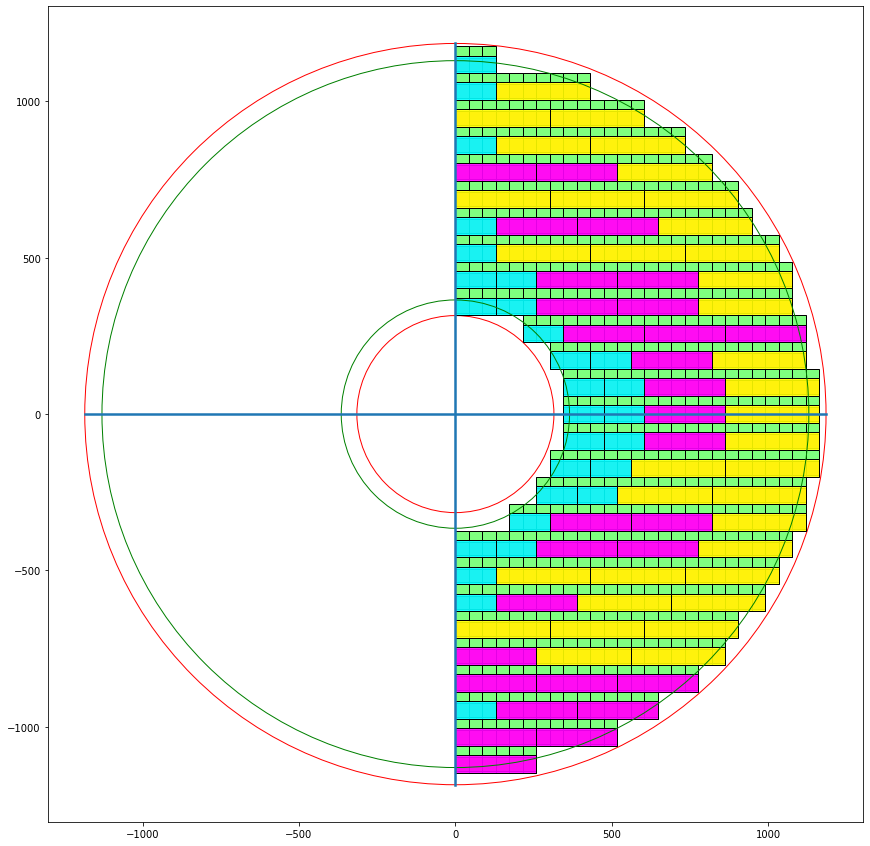

In [163]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

modules = []

#modules += fillDeeWithModules(-28.25,-1163.7)[0]

#modules += fillDee(-28.25-((56.5+29.5)*15),0, showRB=True, showPB=True, honesty='High')[0]
modules += fillDee(0,-module_y/2-((module_y+PB_y)*15), xmax=1185, showRB=True, showPB=True, honesty='High', PB='right')[0]

#modules += fillDeeWithPBs(28.25-(56.5+29.5)*15,0,xmax=disk_outer-PB_x*2)

#modules += fillDeeWithModules(-56.5-14.75-((56.5+29.5)*15),0)[0]
#modules += fillDeeWithPBs(56.5+14.75-(56.5+29.5)*15,0,xmax=disk_outer-PB_x*4)

#modules += fillDeeWithModules(-56.5-14.75-((56.5+29.5)*15),-1163.7,ymax=0)[0]
#modules += fillDeeWithPBs(56.5+14.75-(56.5+29.5)*15,-1163.7,ymax=0, xmax=0)
#modules = fillQuadrantWithModules(-28.25-((56.5+29.5)*15),-1163.7)
#modules = fillQuadrantWithModules(-56.5-((56.5+29.5)*15),-1163.7)

#modules += fillDeeWithModules(-28.25-((56.5+29.5)*15),-1163.7)[0]
#modules += fillDeeWithModules(-56.5-14.75-((56.5+29.5)*15),-1163.7)[0]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)
for m in modules:
    plt.gca().add_patch(m)

hori = plt.Line2D((-1185, 1185), (0, 0), lw=2.5)
vert = plt.Line2D((0, 0), (-1185, 1185), lw=2.5)

plt.gca().add_line(hori)
plt.gca().add_line(vert)

coverage_inner = plt.Circle((0, 0), 365,fill=None, edgecolor='green')
coverage_outer = plt.Circle((0, 0), 1130,fill=None, edgecolor='green')
plt.gca().add_patch(coverage_inner)
plt.gca().add_patch(coverage_outer)

plt.axis('scaled')
plt.show()

Number of RBs: 91


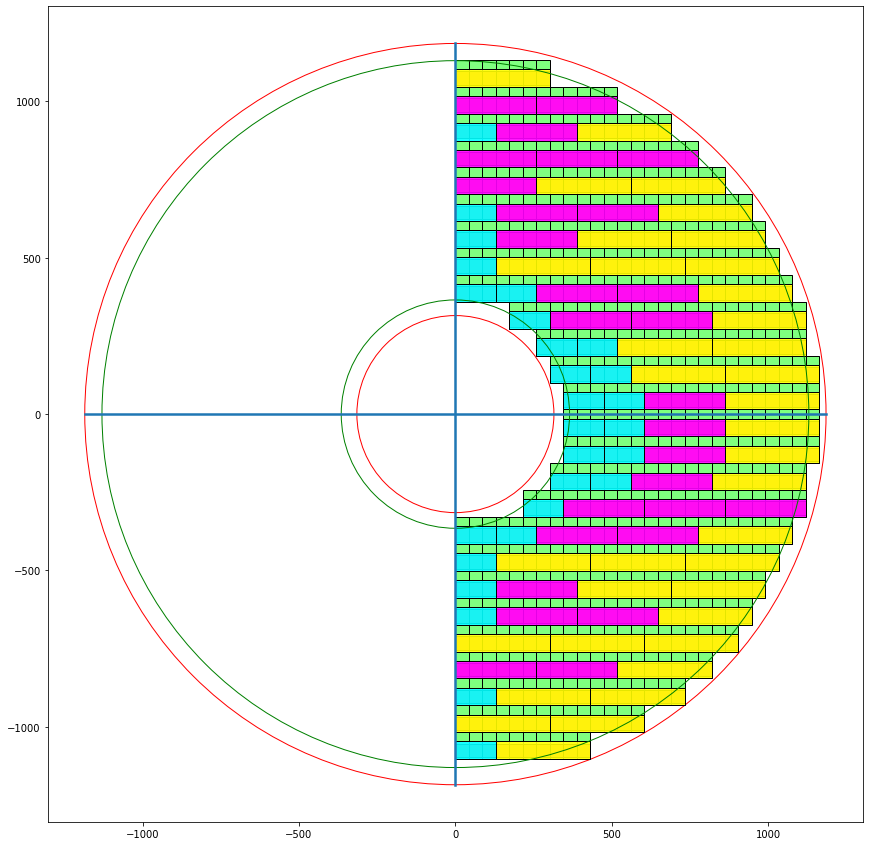

In [164]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

modules = []

modules += fillDee(0,-module_y-PB_y/2-((module_y+PB_y)*15), showRB=True, showPB=True, honesty='High', PB='right')[0]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)
for m in modules:
    plt.gca().add_patch(m)

hori = plt.Line2D((-1185, 1185), (0, 0), lw=2.5)
vert = plt.Line2D((0, 0), (-1185, 1185), lw=2.5)

plt.gca().add_line(hori)
plt.gca().add_line(vert)

coverage_inner = plt.Circle((0, 0), 365,fill=None, edgecolor='green')
coverage_outer = plt.Circle((0, 0), 1130,fill=None, edgecolor='green')
plt.gca().add_patch(coverage_inner)
plt.gca().add_patch(coverage_outer)

plt.axis('scaled')
plt.show()

Number of RBs: 0
Number of RBs: 0
Number of RBs: 0
Number of RBs: 0


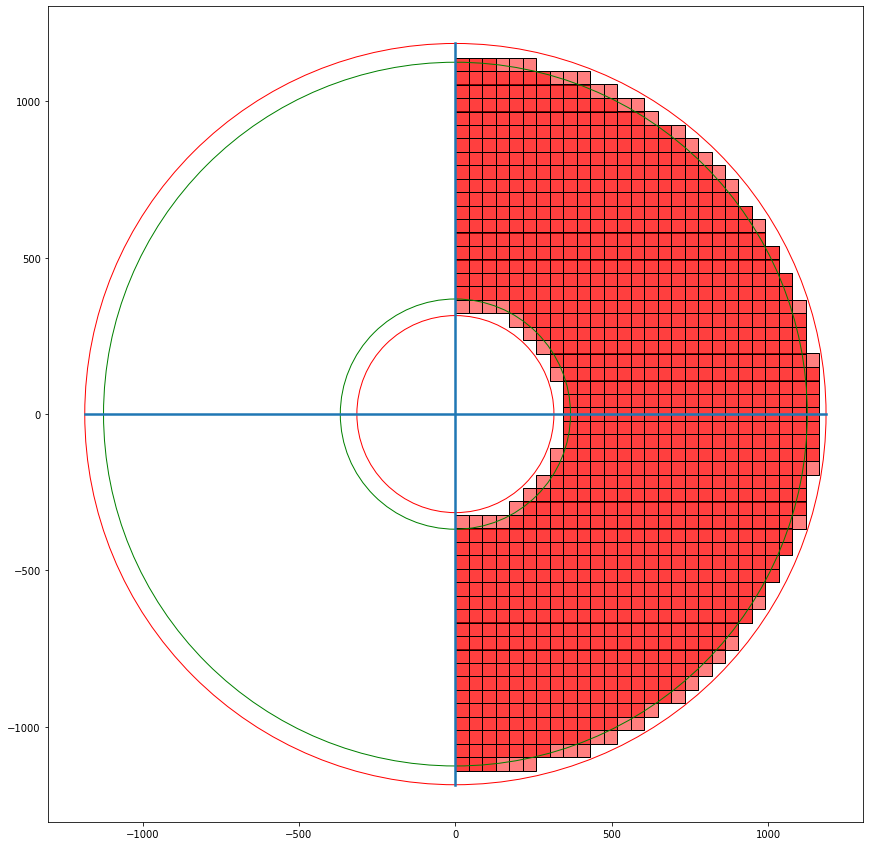

2.7951725370702523
1.7074114360431305
Number of modules 2008


In [165]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

modules = []

modules += fillDee(0,-module_y/2-((module_y+PB_y)*15), xmax=1185, ymax=1185, showRB=False, showPB=False, honesty='High', PB='left', onlyActive=True)[0]
modules += fillDee(0,-module_y-PB_y/2-((module_y+PB_y)*15), xmax=1185, ymax=1185, showRB=False, showPB=False, honesty='High', PB='left', onlyActive=True)[0]

modules += fillDee(0,-module_y/2-((module_y+PB_y)*15), xmax=1185, ymax=1185, showRB=False, showPB=False, honesty='High', PB='right', onlyActive=True)[0]
modules += fillDee(0,-module_y-PB_y/2-((module_y+PB_y)*15), xmax=1185, ymax=1185, showRB=False, showPB=False, honesty='High', PB='right', onlyActive=True)[0]



plt.gca().add_patch(inner)
plt.gca().add_patch(outer)
for m in modules:
    plt.gca().add_patch(m)

hori = plt.Line2D((-1185, 1185), (0, 0), lw=2.5)
vert = plt.Line2D((0, 0), (-1185, 1185), lw=2.5)

plt.gca().add_line(hori)
plt.gca().add_line(vert)

coverage_inner = plt.Circle((0, 0), 368,fill=None, edgecolor='green')
coverage_outer = plt.Circle((0, 0), 1125,fill=None, edgecolor='green')
plt.gca().add_patch(coverage_inner)
plt.gca().add_patch(coverage_outer)

plt.axis('scaled')
plt.show()

# realistic coverage, max eta
max_eta = getEta(368)
# realistic coverage, min eta
min_eta = getEta(1125)
print (max_eta)
print (min_eta)
print ("Number of modules", len(modules))

In [256]:
print 2*sum([0, 0, 6, 12, 15, 18, 20, 21, 23, 24, 25, 26, 21, 20, 19, 19, 19, 20, 21, 26, 25, 24, 23, 21, 20, 18, 15, 12, 6, 0])
print 2*sum([0, 0, 0, 10, 14, 17, 19, 21, 22, 23, 24, 25, 22, 20, 20, 19, 19, 20, 20, 22, 25, 24, 23, 22, 21, 19, 17, 14, 10, 0])

1038
1024


In [78]:
1185/56.5

20.97345132743363

In [106]:
# ideal coverage, max eta
max_eta = getEta(315)
# ideal coverage, min eta
min_eta = getEta(1185)
print max_eta
print min_eta

2.94968703331
1.65892031696


In [24]:
getRBs(3,900)

[3]

In [140]:
92*4+91*4

732

In [153]:
2350*4

9400